## Clustering & Classification: Olympic Atheletes

In this exercise, the task is to explore the olympic athelete dataset.

Features to start with:
 - Age
 - Height
 - Weight

Non-Features:
 - Sex (for splitting dataset)
 - Sport (for splitting dataset)
 - Year (for filtering NaN)
 - Medal (our truth comparison?)

Task:
- Split dataset by Sport
- Run classification algorithms to predict the medals won
- Try clustering algorithms to see if we can get the clusters to correlate to type of medals won.
  - KMeans
  - Gaussian Mixture Models
  - DBSCAN


## Dataset

https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results

Columns:

```
ID - Athelete ID
Name
Sex
Age
Height
Weight
Team
NOC - Code Name of Country (represented by the athelete)
Games - Which Olympic Games (year and city)
Year
Season - Winter or Summer Olympics
City - City that held the games
Sport - Sport
Event - Sport Event (e.g. Basketball finals)
Medal - Gold, Silver, Bronze, or NaN (for No Medal)
```

Note that there can be multiple entries per athelete, since an athelete can participate in multiple events, or return multiple years.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Explore Dataset

Features for partitioning the dataset:
 - Sport
 - Sex

Features to cluster:
 - Age
 - Height
 - Weight
 - Team
 - Year
 - Medal (this is our clustering comparison)

Data Processing
 - Convert NaN medals to 'None'
 - Drop rows earlier than 1960
   - because of too many missing Height and Weight values
   - see analysis here: https://www.kaggle.com/goldendime/advanced-techniques-for-dealing-w-missing-data
    - Fill other NaN values with mean (this is a crude interpolation)
 - Label Encode
 - Scale

In [2]:
df = pd.read_csv('D:/tmp/olympic-atheletes/athlete_events.csv',
                 usecols=['Age', 'Height', 'Weight',
                          'Team', 'Sex', 'Sport', 'Medal', 'Year'],
                 parse_dates=['Year'])
df.head()

,Sex,Age,Height,Weight,Team,Year,Sport,Medal
0,M,24.0,180.0,80.0,China,1992-01-01,Basketball,NaN
1,M,23.0,170.0,60.0,China,2012-01-01,Judo,NaN
2,M,24.0,NaN,NaN,Denmark,1920-01-01,Football,NaN
3,M,34.0,NaN,NaN,Denmark/Sweden,1900-01-01,Tug-Of-War,Gold
4,F,21.0,185.0,82.0,Netherlands,1988-01-01,Speed Skating,NaN


In [3]:
df.describe()

,Age,Height,Weight
count,261642.000000,210945.000000,208241.000000
mean,25.556898,175.338970,70.702393
std,6.393561,10.518462,14.348020
min,10.000000,127.000000,25.000000
25%,21.000000,168.000000,60.000000
50%,24.000000,175.000000,70.000000
75%,28.000000,183.000000,79.000000
max,97.000000,226.000000,214.000000


In [4]:
df.dtypes

Sex               object
Age              float64
Height           float64
Weight           float64
Team              object
Year      datetime64[ns]
Sport             object
Medal             object
dtype: object

In [5]:
df.Medal.unique()

array([nan, 'Gold', 'Bronze', 'Silver'], dtype=object)

In [6]:
# Convert NaN medals to 'None'

df['Medal'].fillna(value='None', inplace=True)

In [7]:
df.Medal.unique()

array(['None', 'Gold', 'Bronze', 'Silver'], dtype=object)

In [8]:
# Drop rows earlier than 1960
df.drop(index=df[df.Year < '1960'].index, inplace=True)

In [9]:
# check if there are still entries before 1960
print(df[df.Year < '1960'])

Empty DataFrame
Columns: [Sex, Age, Height, Weight, Team, Year, Sport, Medal]
Index: []


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209072 entries, 0 to 271115
Data columns (total 8 columns):
Sex       209072 non-null object
Age       207957 non-null float64
Height    197953 non-null float64
Weight    197248 non-null float64
Team      209072 non-null object
Year      209072 non-null datetime64[ns]
Sport     209072 non-null object
Medal     209072 non-null object
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 14.4+ MB


In [11]:
# try to see if we can fill na using mean
mean_heights = pd.DataFrame(df.groupby(['Sport', 'Sex'])['Height'].mean())

mean_heights.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 97 entries, (Alpine Skiing, F) to (Wrestling, M)
Data columns (total 1 columns):
Height    97 non-null float64
dtypes: float64(1)
memory usage: 1.5+ KB


In [12]:
# Since all heights are available, let's fillna with them
# based on sport and gender
#
# fillna does nothing if the value isn't NaN, so it is
# safe to loop over and do a fillna per combination

for row in mean_heights.itertuples():
    sport = row.Index[0]
    gender = row.Index[1]
    height = row[1] # row.Height also works, but this is more generic
                    # and allows us to abstract this into a function
    
    # fillna inplace=True doesn't work because
    # somehow internally a copy is used and not a view (bug?)
    df.loc[(df.Sport == sport) & (df.Sex == gender), 'Height'] = \
        df.loc[(df.Sport == sport) & (df.Sex == gender), 'Height'].fillna(height)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209072 entries, 0 to 271115
Data columns (total 8 columns):
Sex       209072 non-null object
Age       207957 non-null float64
Height    209072 non-null float64
Weight    197248 non-null float64
Team      209072 non-null object
Year      209072 non-null datetime64[ns]
Sport     209072 non-null object
Medal     209072 non-null object
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 14.4+ MB


In [14]:
# repeat the same process for weight and age
# define a helper function

def fillna_with_mean_by_sport_and_gender(df, column):
    """Fills NaN values using the mean value, grouped by
    sport and gender
    Args:
        df: dataframe to update
        column: column to fillna
    """
    means = pd.DataFrame(df.groupby(['Sport', 'Sex'])[column].mean())

    for row in means.itertuples():
        sport = row.Index[0]
        gender = row.Index[1]
        mean = row[1]
    
        # fillna inplace=True doesn't work because
        # somehow internally a copy is used and not a view (bug?)
        df.loc[(df.Sport == sport) & (df.Sex == gender), column] = \
            df.loc[(df.Sport == sport) & (df.Sex == gender), column].fillna(mean)

In [15]:
fillna_with_mean_by_sport_and_gender(df, 'Weight')
fillna_with_mean_by_sport_and_gender(df, 'Age')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209072 entries, 0 to 271115
Data columns (total 8 columns):
Sex       209072 non-null object
Age       209072 non-null float64
Height    209072 non-null float64
Weight    209072 non-null float64
Team      209072 non-null object
Year      209072 non-null datetime64[ns]
Sport     209072 non-null object
Medal     209072 non-null object
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 14.4+ MB


In [16]:
from sklearn.preprocessing import LabelEncoder

team_le = LabelEncoder()
df['Team'] = team_le.fit_transform(df.Team)

### Partition dataset and select features

In [17]:
# see which cluster we want to create by counting
# the number of entries
df.groupby(['Sport', 'Sex'])['Medal'].count()

Sport                  Sex
Alpine Skiing          F       2997
                       M       4588
Archery                F        974
                       M       1095
Athletics              F      10571
                       M      17521
Badminton              F        740
                       M        717
Baseball               M        894
Basketball             F       1256
                       M       2331
Beach Volleyball       F        276
                       M        288
Biathlon               F       1863
                       M       3030
Bobsleigh              F        143
                       M       2267
Boxing                 F         72
                       M       4589
Canoeing               F       1347
                       M       4212
Cross Country Skiing   F       3295
                       M       4806
Curling                F        222
                       M        225
Cycling                F       1394
                       M       6523
D

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def plot_pca(df, title):
    X = df.loc[:, ['Height', 'Weight', 'Age', 'Team']]
    medals = df.Medal
    
    X_2d = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(X))

    fig, ax = plt.subplots()
    
    medal_types = ['Gold', 'Silver', 'Bronze']
    colors = ['gold', 'silver', 'brown']

    for medal, color in zip(medal_types, colors):
        ax.scatter(X_2d[medals==medal, 0],
                   X_2d[medals==medal, 1],
                   color=color, label=medal)

    ax.set(title=title)
        
    ax.legend()

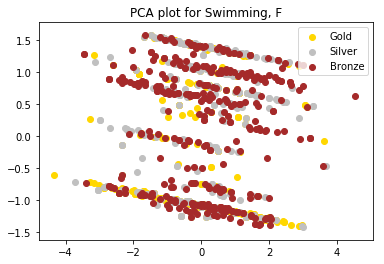

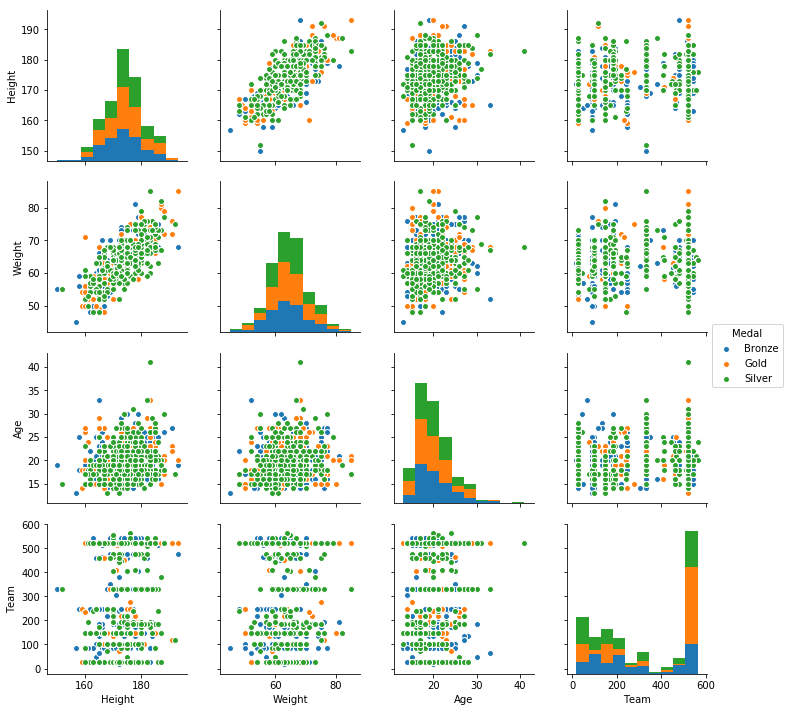

In [29]:
# Try some combinations of sports and genders

# https://seaborn.pydata.org/generated/seaborn.pairplot.html
import seaborn as sns

sport_df = df.loc[(df.Sport == 'Swimming') & (df.Sex == 'F') & \
                  (df.Medal != 'None')]

plot_pca(sport_df, 'PCA plot for Swimming, F')

sns.pairplot(sport_df[['Height', 'Weight', 'Age', 'Team', 'Medal']],
             hue='Medal')
plt.show()

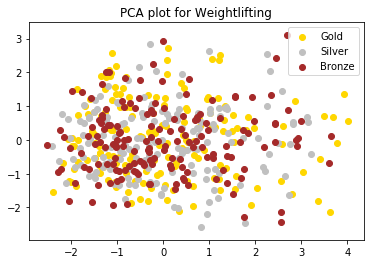

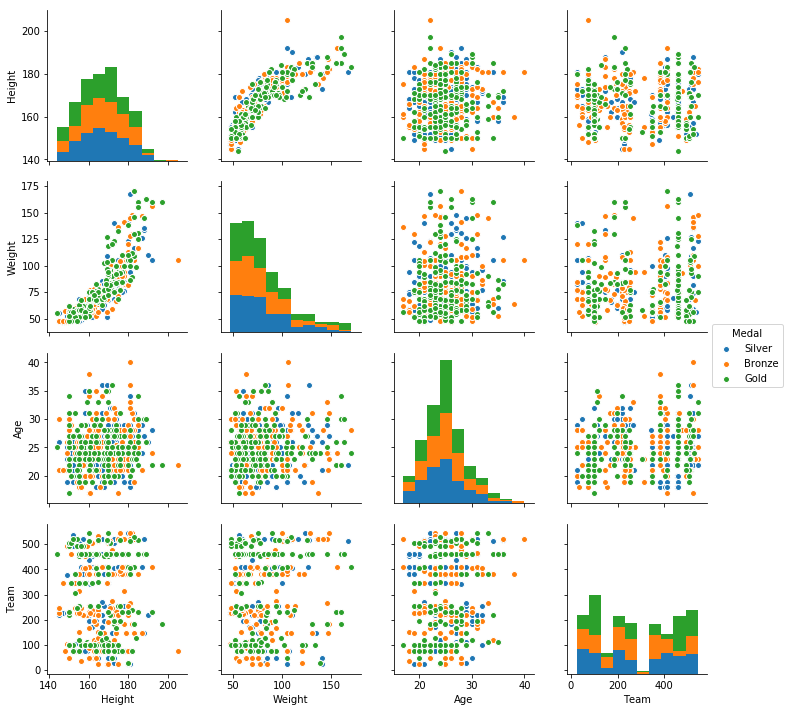

In [31]:
sport_df = df.loc[(df.Sport == 'Weightlifting') & \
                  (df.Medal != 'None')]

plot_pca(sport_df, 'PCA plot for Weightlifting')

sns.pairplot(sport_df[['Height', 'Weight', 'Age', 'Team', 'Medal']],
             hue='Medal')
plt.show()

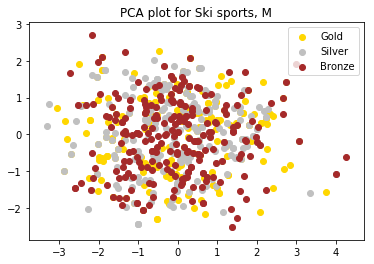

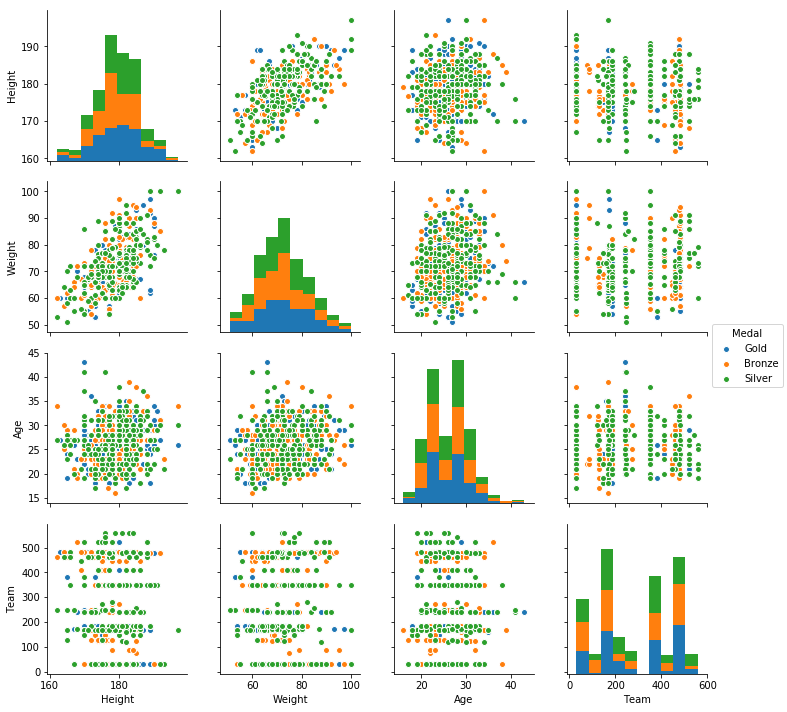

In [32]:
sport_df = df.loc[((df.Sport == 'Alpine Skiing') |
                   (df.Sport == 'Cross Country Skiing') |
                   (df.Sport == 'Ski Jumping')) &
                  (df.Sex == 'M') &
                  (df.Medal != 'None')]

plot_pca(sport_df, 'PCA plot for Ski sports, M')

sns.pairplot(sport_df[['Height', 'Weight', 'Age', 'Team', 'Medal']],
             hue='Medal')
plt.show()

## Classification

The classes are not linearly separable, so we try:
- Nearest Neighbors
- SVC
- Decision Tree

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score

def fit_classifiers(df):
    """Fits classifiers
    Args:
        df: originating dataframe
    """    
    X = df.loc[:, ['Height', 'Weight', 'Age', 'Team']]
    y = df.Medal
    
    # train-test-split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    # scale X
    X_scaler = StandardScaler()
    X_train_scaled = X_scaler.fit_transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    # initialize classifiers
    classifiers = [
        GridSearchCV(KNeighborsClassifier(),
                     param_grid={'n_neighbors' : [3, 5, 10, 20]}),
        GridSearchCV(RandomForestClassifier(random_state=42),
                     param_grid={'n_estimators' : [5, 10, 20],
                                 'max_depth' : [3, 5, 10, 15, 20]}),
        GridSearchCV(SVC(random_state=42),
                     param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                                 'gamma': [1e-3, 1e-2, 1e-1, 1, 10]}),
        GridSearchCV(MLPClassifier(random_state=42, max_iter=500),
                     param_grid={'learning_rate' : ['constant', 'adaptive'],
                                 'alpha' : [1e-4, 1e-3, 1e-2, 1e-1]})
    ]
    
    # fit classifiers
    for clf in classifiers:
        clf.fit(X_train_scaled, y_train)

        y_pred = clf.predict(X_test_scaled)
        
        if (hasattr(clf, 'decision_function')):
            y_score = clf.decision_function(X_test_scaled)
        else:
            y_score = clf.predict_proba(X_test_scaled)
                    
        print(clf.best_params_)
        print(classification_report(y_test, y_pred))

In [23]:
sport_df = df.loc[(df.Sport == 'Swimming') & (df.Sex == 'F') & \
                  (df.Medal != 'None')]

fit_classifiers(sport_df)

{'n_neighbors': 20}
             precision    recall  f1-score   support

     Bronze       0.40      0.40      0.40        83
       Gold       0.46      0.57      0.51       105
     Silver       0.43      0.32      0.37       102

avg / total       0.43      0.43      0.43       290

{'max_depth': 5, 'n_estimators': 10}
             precision    recall  f1-score   support

     Bronze       0.48      0.61      0.54        83
       Gold       0.57      0.67      0.62       105
     Silver       0.44      0.26      0.33       102

avg / total       0.50      0.51      0.49       290

{'C': 1, 'gamma': 0.1}
             precision    recall  f1-score   support

     Bronze       0.35      0.27      0.30        83
       Gold       0.48      0.66      0.55       105
     Silver       0.38      0.31      0.34       102

avg / total       0.41      0.42      0.41       290

{'alpha': 0.1, 'learning_rate': 'constant'}
             precision    recall  f1-score   support

     Bronze       

In [24]:
sport_df = df.loc[(df.Sport == 'Weightlifting') & \
                  (df.Medal != 'None')]

fit_classifiers(sport_df)

{'n_neighbors': 5}
             precision    recall  f1-score   support

     Bronze       0.40      0.57      0.47        42
       Gold       0.36      0.38      0.37        42
     Silver       0.22      0.10      0.14        39

avg / total       0.33      0.36      0.33       123

{'max_depth': 20, 'n_estimators': 20}
             precision    recall  f1-score   support

     Bronze       0.34      0.40      0.37        42
       Gold       0.41      0.31      0.35        42
     Silver       0.24      0.26      0.25        39

avg / total       0.33      0.33      0.33       123

{'C': 10, 'gamma': 1}
             precision    recall  f1-score   support

     Bronze       0.37      0.45      0.41        42
       Gold       0.36      0.33      0.35        42
     Silver       0.27      0.23      0.25        39

avg / total       0.34      0.34      0.34       123

{'alpha': 0.0001, 'learning_rate': 'constant'}
             precision    recall  f1-score   support

     Bronze     

In [25]:
sport_df = df.loc[((df.Sport == 'Alpine Skiing') |
                   (df.Sport == 'Cross Country Skiing') |
                   (df.Sport == 'Ski Jumping')) &
                  (df.Sex == 'M') &
                  (df.Medal != 'None')]

fit_classifiers(sport_df)

{'n_neighbors': 5}
             precision    recall  f1-score   support

     Bronze       0.40      0.64      0.49        64
       Gold       0.36      0.38      0.37        52
     Silver       0.32      0.10      0.15        62

avg / total       0.36      0.38      0.34       178

{'max_depth': 5, 'n_estimators': 20}
             precision    recall  f1-score   support

     Bronze       0.41      0.47      0.44        64
       Gold       0.30      0.31      0.30        52
     Silver       0.29      0.24      0.26        62

avg / total       0.34      0.34      0.34       178

{'C': 1, 'gamma': 1}
             precision    recall  f1-score   support

     Bronze       0.40      0.58      0.47        64
       Gold       0.36      0.37      0.36        52
     Silver       0.33      0.18      0.23        62

avg / total       0.37      0.38      0.36       178



C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\neural_network\multilayer_perceptr

{'alpha': 0.01, 'learning_rate': 'constant'}
             precision    recall  f1-score   support

     Bronze       0.35      0.50      0.41        64
       Gold       0.31      0.31      0.31        52
     Silver       0.42      0.24      0.31        62

avg / total       0.36      0.35      0.35       178



## Clustering

In [61]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import v_measure_score

def fit_clusterers(df):
    """Fits clusterers
    Args:
        df: dataframe
    Returns:
        tuple: (clusterers, X_scaler)
    """
    X = df.loc[:, ['Height', 'Weight', 'Age', 'Team']]
    y = df.Medal
    
    # scale X
    X_scaler = StandardScaler()
    X_scaled = X_scaler.fit_transform(X)
    
    # initialize clusterers, these ones use fit_predict
    clusterers = [
        DBSCAN(eps=.5, min_samples=20), # tunes how many clusters are found
        KMeans(n_clusters=3)
    ]
    
    for clu in clusterers:
        y_pred = clu.fit_predict(X_scaled)
        print(clu.__class__)
        print(v_measure_score(y, y_pred))
    
        X['cluster'] = y_pred
        g = sns.pairplot(X, hue='cluster',
                     vars=['Height', 'Weight', 'Age', 'Team'])
        g.fig.suptitle(clu.__class__)
    
    # initialize clusterers, these ones use fit, then predict
    # expect Gaussian Mixtures to perform slightly better
    # with height and weight distribution
    clusterers = [
        BayesianGaussianMixture(n_components=3),
        GaussianMixture(n_components=3)
    ]
    
    for clu in clusterers:
        y_pred = clu.fit(X_scaled).predict(X_scaled)
        print(clu.__class__)
        print(v_measure_score(y, y_pred))
        
        X['cluster'] = y_pred
        g = sns.pairplot(X, hue='cluster',
                     vars=['Height', 'Weight', 'Age', 'Team'])
        g.fig.suptitle(clu.__class__)

<class 'sklearn.cluster.dbscan_.DBSCAN'>
0.012573961052241726
<class 'sklearn.cluster.k_means_.KMeans'>
0.01578653554603369
<class 'sklearn.mixture.bayesian_mixture.BayesianGaussianMixture'>
0.028857085292036667
<class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>
0.059915657629314466


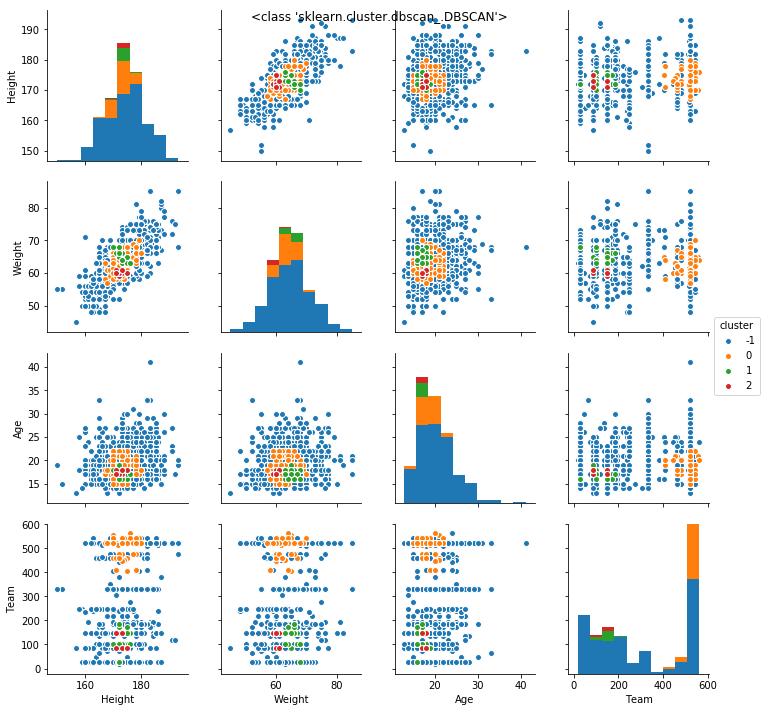

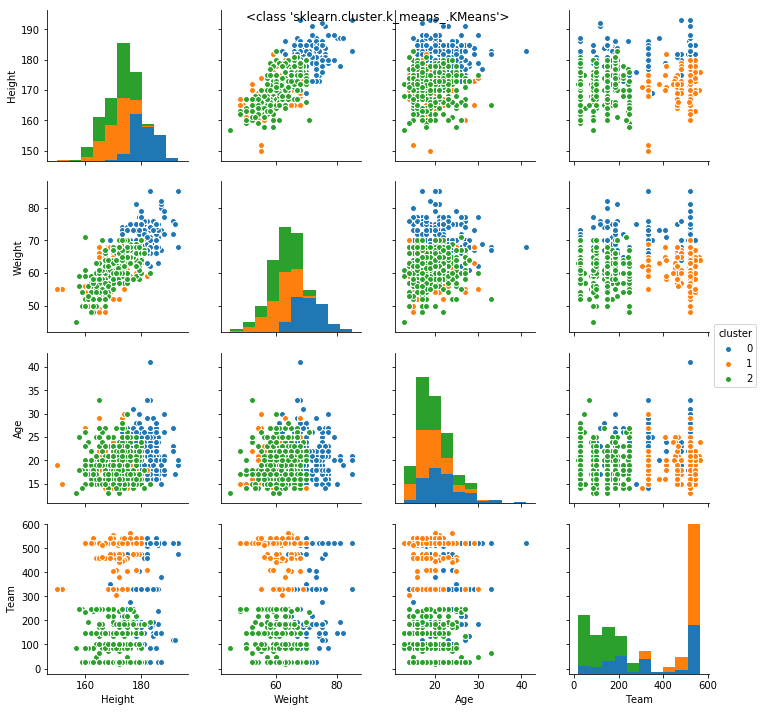

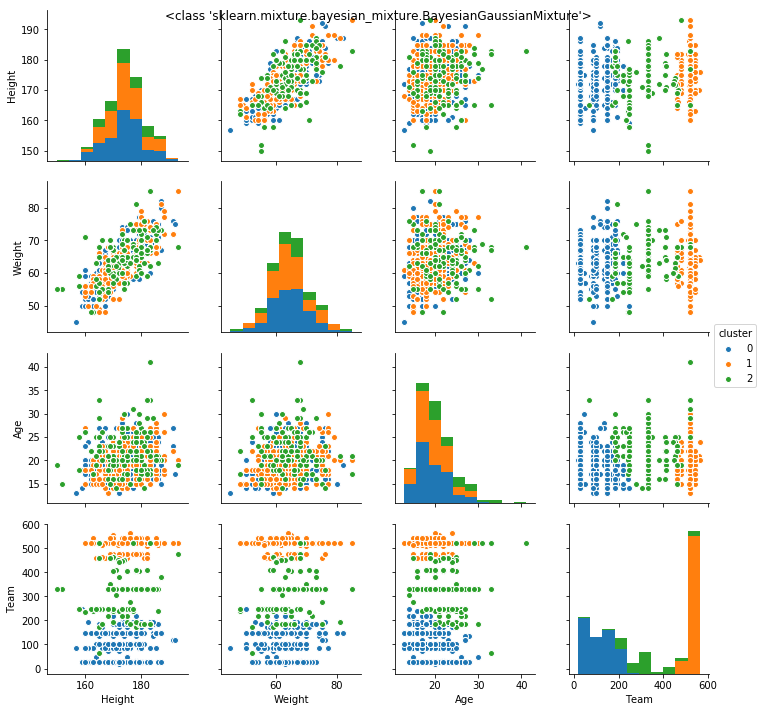

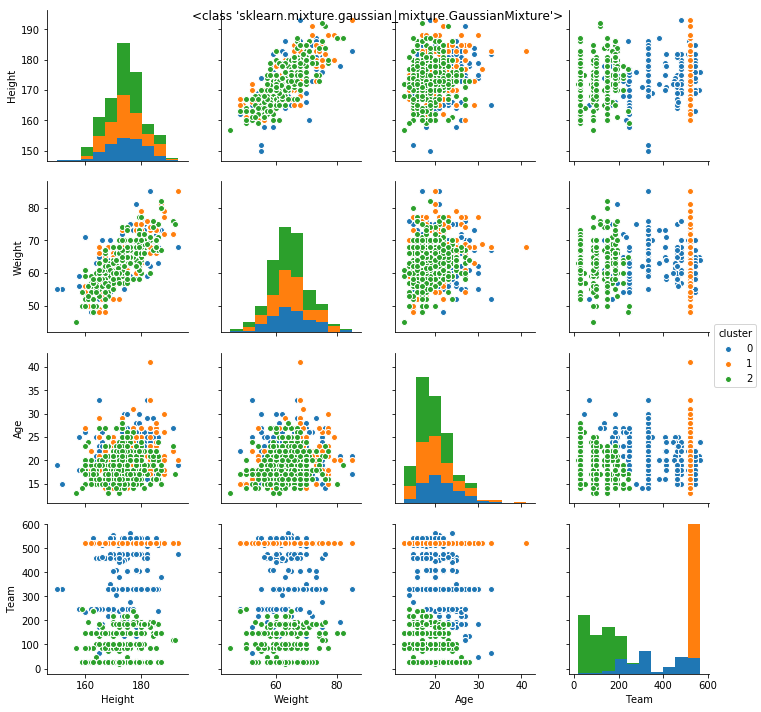

In [62]:
sport_df = df.loc[(df.Sport == 'Swimming') & (df.Sex == 'F') & \
                  (df.Medal != 'None')]

fit_clusterers(sport_df)

<class 'sklearn.cluster.dbscan_.DBSCAN'>
0.0
<class 'sklearn.cluster.k_means_.KMeans'>
0.0007693106966743738
<class 'sklearn.mixture.bayesian_mixture.BayesianGaussianMixture'>
0.0015168042754470693
<class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>
0.0015736446724862198


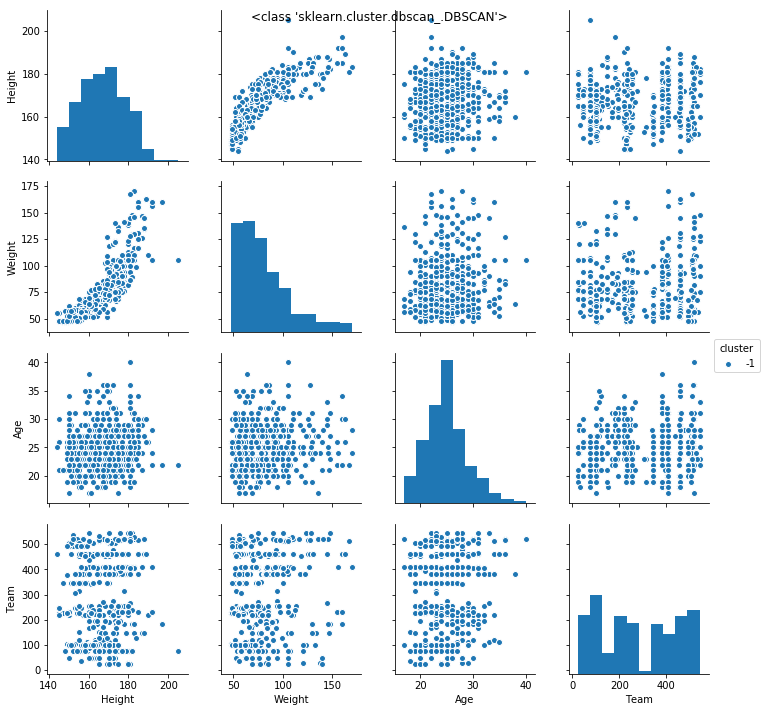

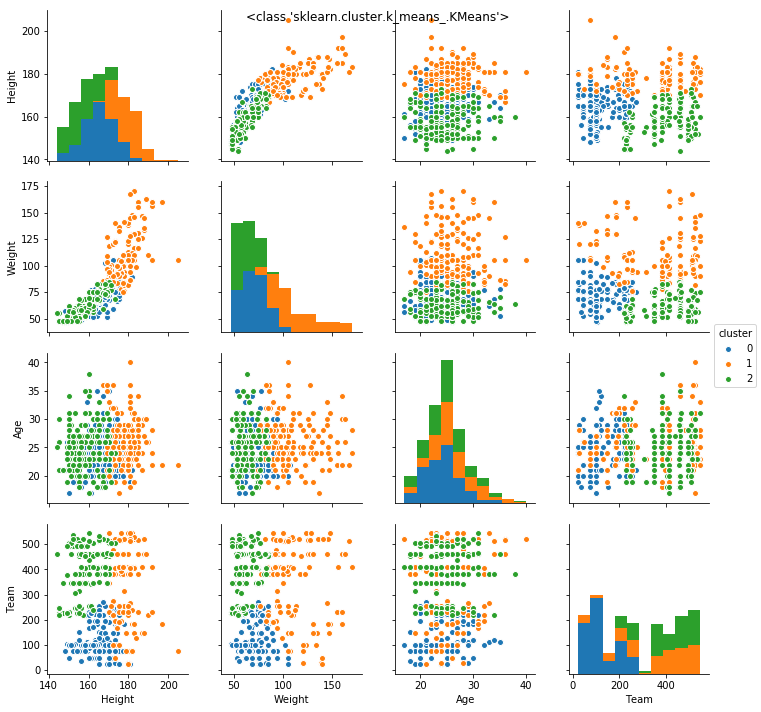

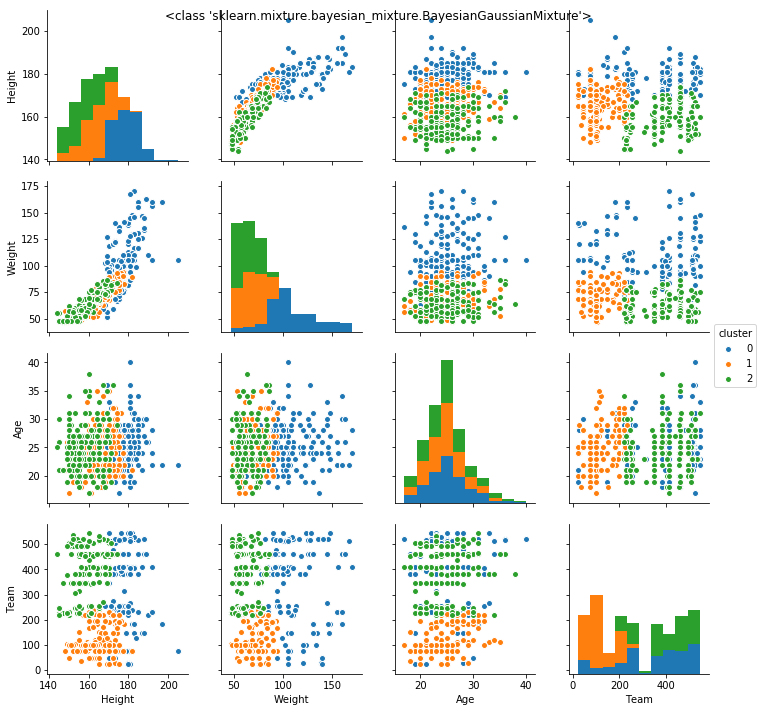

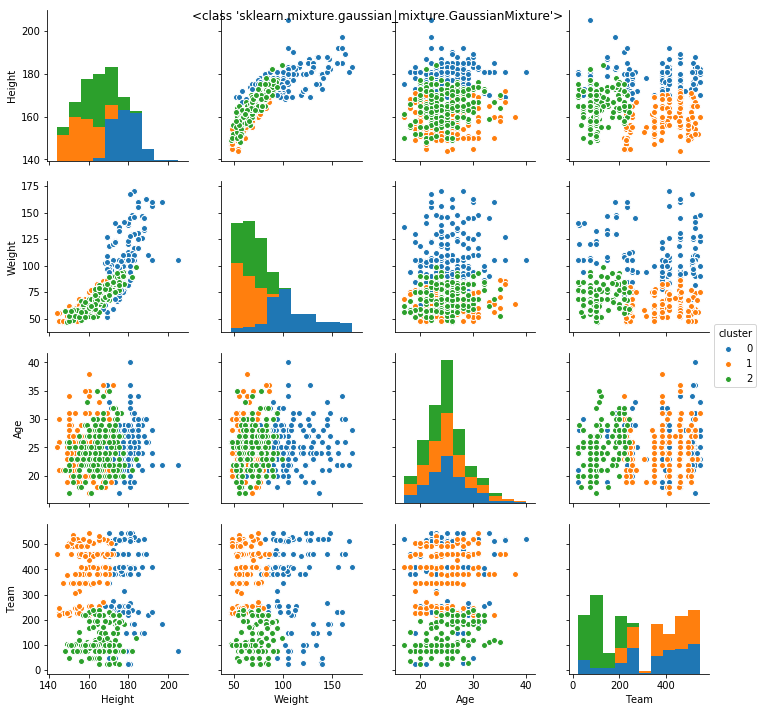

In [63]:
sport_df = df.loc[(df.Sport == 'Weightlifting') & \
                  (df.Medal != 'None')]

fit_clusterers(sport_df)

<class 'sklearn.cluster.dbscan_.DBSCAN'>
-5.053088404598894e-16
<class 'sklearn.cluster.k_means_.KMeans'>
0.0015316429468340848


C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


<class 'sklearn.mixture.bayesian_mixture.BayesianGaussianMixture'>
0.002033284738285008
<class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>
0.0034165473899669075


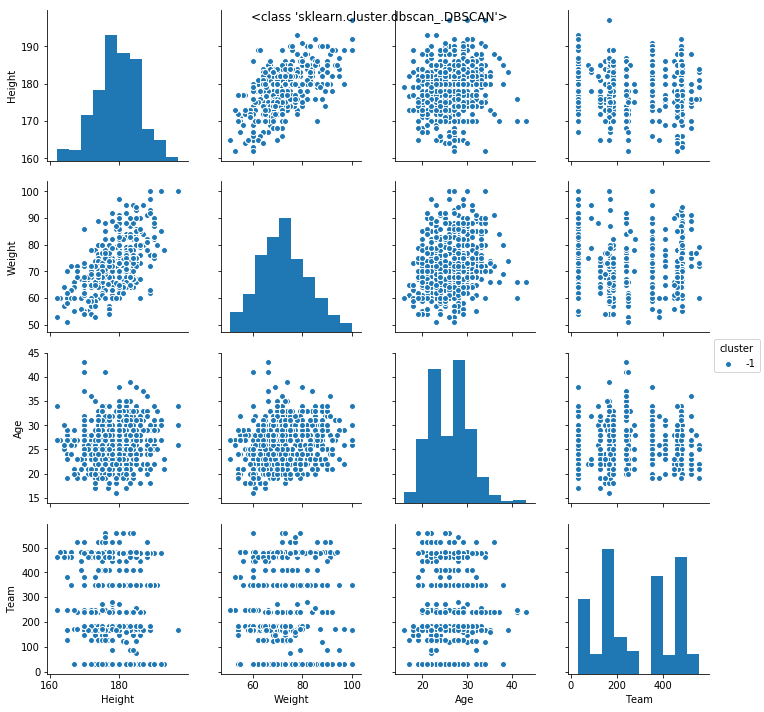

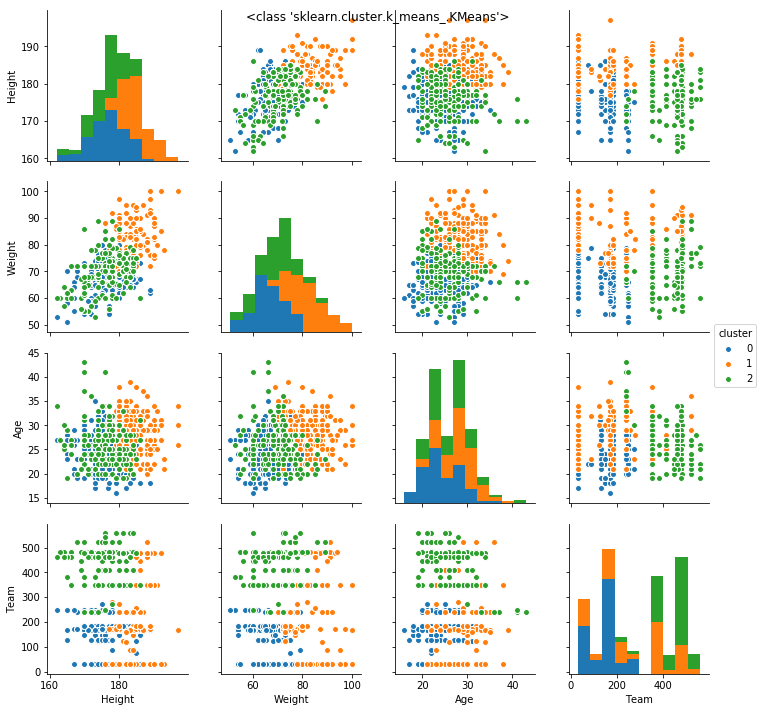

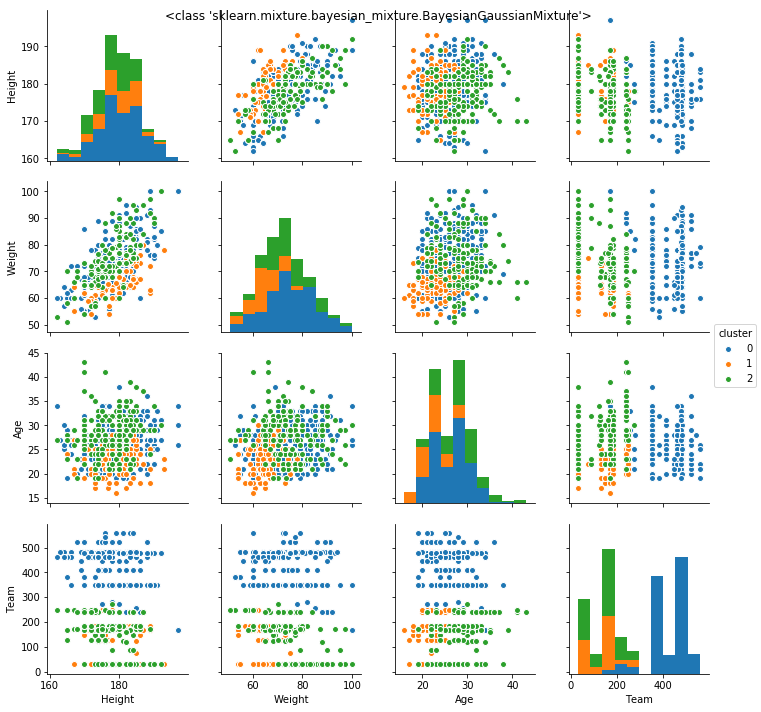

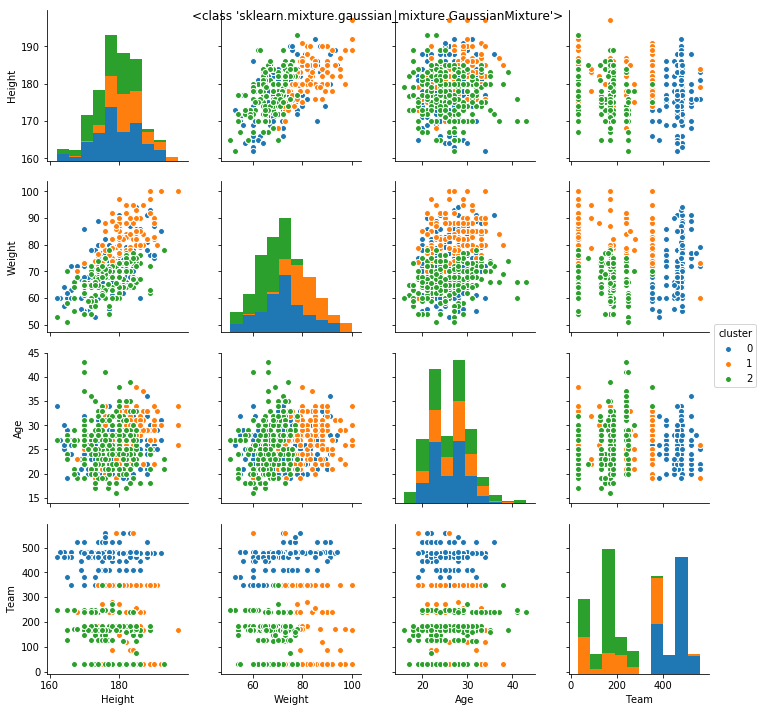

In [64]:
sport_df = df.loc[((df.Sport == 'Alpine Skiing') |
                   (df.Sport == 'Cross Country Skiing') |
                   (df.Sport == 'Ski Jumping')) &
                  (df.Sex == 'M') &
                  (df.Medal != 'None')]

fit_clusterers(sport_df)